In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

import util.RAVDESS_dataset_util as Rd
import multimodal_vae
from train_mvae import build_model, train

from config_args import ConfigModelArgs, ConfigTrainArgs

In [3]:
cfg_model = ConfigModelArgs()
cfg_train = ConfigTrainArgs()

In [4]:
face_dataset = Rd.FaceEmotionDataset(
    root_dir=cfg_model.dataset_path,
    transform=transforms.Compose
    ([
        Rd.Rescale(cfg_model.img_size), 
        Rd.CenterCrop(cfg_model.img_size), 
        Rd.ToTensor()
    ]))

trainingset_len = len(face_dataset) // 100 * 95
testset_len = len(face_dataset) - trainingset_len
training_dataset, testing_dataset = torch.utils.data.random_split(
    face_dataset, 
    [trainingset_len, testset_len],
    #generator=torch.Generator().manual_seed(42)
)

dataset_loader = DataLoader(training_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

testset_loader = DataLoader(testing_dataset, batch_size=cfg_train.batch_size,
                        shuffle=True, num_workers=cfg_train.num_workers)

print('training set size: ',trainingset_len,'\ntest set size: ',testset_len)

training set size:  98 
test set size:  9769


In [5]:
model_args = {
    'cat_dim' : cfg_model.cat_dim,
    'latent_space_dim' : cfg_model.z_dim,
    'hidden_dim' : cfg_model.hidden_dim,
    'num_channels' : cfg_model.channel_dim,
    'loss_weights' : cfg_model.loss_weights,
    'expert_type' : cfg_model.expert_type,
    'use_cuda' : True
}

model: torch.nn.Module = build_model(**model_args).double()

In [6]:
training_losses = train(
    mvae_model=model,
    dataset_loader=dataset_loader,
    learning_rate=cfg_train.learning_rate,
    optim_betas=cfg_train.optim_betas,
    num_epochs=cfg_train.num_epochs,
    batch_size=cfg_train.batch_size,
    checkpoint_every=cfg_train.checkpoint_every,
    checkpoint_path=cfg_train.checkpoint_path,
    save_model=cfg_train.save_model,
    seed=cfg_train.seed,
    use_cuda=cfg_train.use_cuda,
    cfg=cfg_train
)

 50%|███████████████               | 1/2 [00:10<00:10, 10.50s/it]

Multimodal losses:
Mean total loss: 4.5833;
Mean reconstruction loss: 4.5398;
Mean kld_loss loss: 4358.5;
Mean faces_reconstruction loss: 3.4994;
Mean emotions_reconstruction loss: 1.0403;

Face losses:
Mean total loss: 3.2558;
Mean reconstruction loss: 3.2118;
Mean kld_loss loss: 4397.1;
Mean faces_reconstruction loss: 3.2118;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0603;
Mean reconstruction loss: 1.0472;
Mean kld_loss loss: 1305.0;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 1.0472;



100%|██████████████████████████████| 2/2 [00:20<00:00, 10.23s/it]

Multimodal losses:
Mean total loss: 2.8389;
Mean reconstruction loss: 2.7952;
Mean kld_loss loss: 4371.9;
Mean faces_reconstruction loss: 1.7549;
Mean emotions_reconstruction loss: 1.0403;

Face losses:
Mean total loss: 1.7059;
Mean reconstruction loss: 1.6616;
Mean kld_loss loss: 4429.6;
Mean faces_reconstruction loss: 1.6616;
Mean emotions_reconstruction loss: 0.0;

Emotion losses:
Mean total loss: 1.0332;
Mean reconstruction loss: 1.0202;
Mean kld_loss loss: 1304.9;
Mean faces_reconstruction loss: 0.0;
Mean emotions_reconstruction loss: 1.0202;



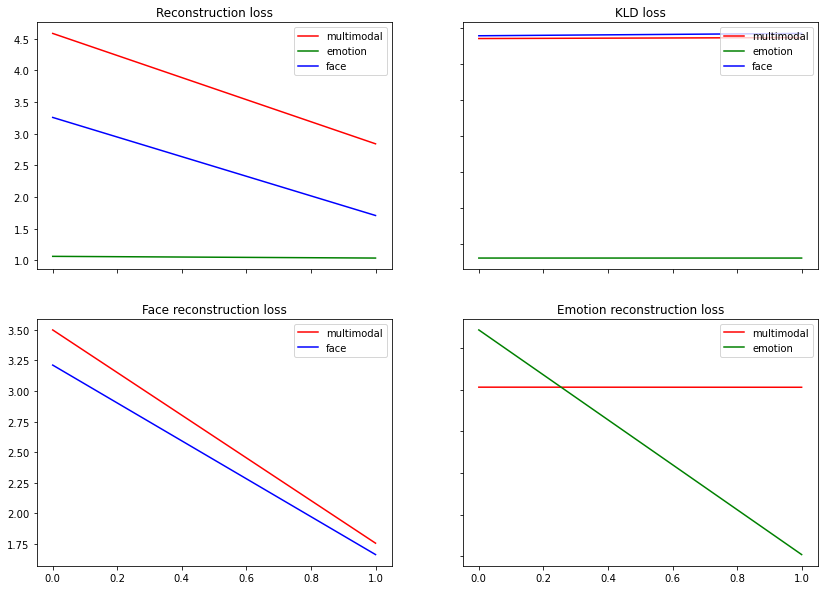

In [51]:
skip_epoch_plot=0

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

ax1.set_title('Reconstruction loss')
ax1.plot(training_losses['multimodal_loss'].total_loss[skip_epoch_plot:], color='red', label='multimodal')
ax1.plot(training_losses['emotion_loss'].total_loss[skip_epoch_plot:], color='green', label='emotion')
ax1.plot(training_losses['face_loss'].total_loss[skip_epoch_plot:], color='blue', label='face')
ax1.legend(loc="upper right")

ax2.set_title('KLD loss')
ax2.plot(training_losses['multimodal_loss'].kld_loss[skip_epoch_plot:], color='red', label='multimodal')
ax2.plot(training_losses['emotion_loss'].kld_loss[skip_epoch_plot:], color='green', label='emotion')
ax2.plot(training_losses['face_loss'].kld_loss[skip_epoch_plot:], color='blue', label='face')
ax2.legend(loc="upper right")

ax3.set_title('Face reconstruction loss')
ax3.plot(training_losses['multimodal_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='red', label='multimodal')
#ax3.plot(training_losses['emotion_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='green', label='emotion')
ax3.plot(training_losses['face_loss'].faces_reconstruction_loss[skip_epoch_plot:], color='blue', label='face')
ax3.legend(loc="upper right")

ax4.set_title('Emotion reconstruction loss')
ax4.plot(training_losses['multimodal_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='red', label='multimodal')
ax4.plot(training_losses['emotion_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='green', label='emotion')
#ax4.plot(training_losses['face_loss'].emotions_reconstruction_loss[skip_epoch_plot:], color='blue', label='face')
ax4.legend(loc="upper right")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in fig.get_axes():
    ax.label_outer()

In [13]:
def testBatch(model, dataset_loader, img_size=64, use_cuda=True):
    model.train()
    plt.figure(figsize = (40,10))
    
    sample = next(iter(dataset_loader))
    images = sample['image']
    labels = sample['cat']
    
    if use_cuda:
        images = images.cuda()
        labels = labels.cuda()
        
    batch_size = images.shape[0]
        
    input_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_array = np.zeros(shape=(img_size, 1, 3), dtype="uint8")
    reconstructed_emotions = []
    
    reconstructed_images, reconstructed_emotions, _, _ = model(faces=None, emotions=labels)

    for idx in range(4):
        input_image = images[idx]
        
        # storing the input image
        input_image_display = np.array(input_image.cpu()*255., dtype='uint8').transpose((1, 2, 0))
        input_array = np.concatenate((input_array, input_image_display), axis=1)
        
        # generating the reconstructed image and adding to array
        input_image = input_image.view(1, 3, img_size, img_size)
        
        reconstructed_img = reconstructed_images[idx].cpu().view(3, img_size, img_size).detach().numpy()
        reconstructed_img = np.array(reconstructed_img*255., dtype='uint8').transpose((1, 2, 0))
        reconstructed_array = np.concatenate((reconstructed_array, reconstructed_img), axis=1)
        
        
    input_array = input_array[:,1:,:]
    reconstructed_array = reconstructed_array[:,1:,:]
    display_array = np.concatenate((input_array, reconstructed_array), axis=0)
    plt.imshow(display_array)
    
    print([Rd.emocat[label.item()] for label in labels[:4]])
    print([Rd.emocat[emo.item()] for emo in torch.argmax(reconstructed_emotions, 1)[:4]])

['neutral', 'happy', 'sad', 'surprised']
['happy', 'happy', 'angry', 'sad']


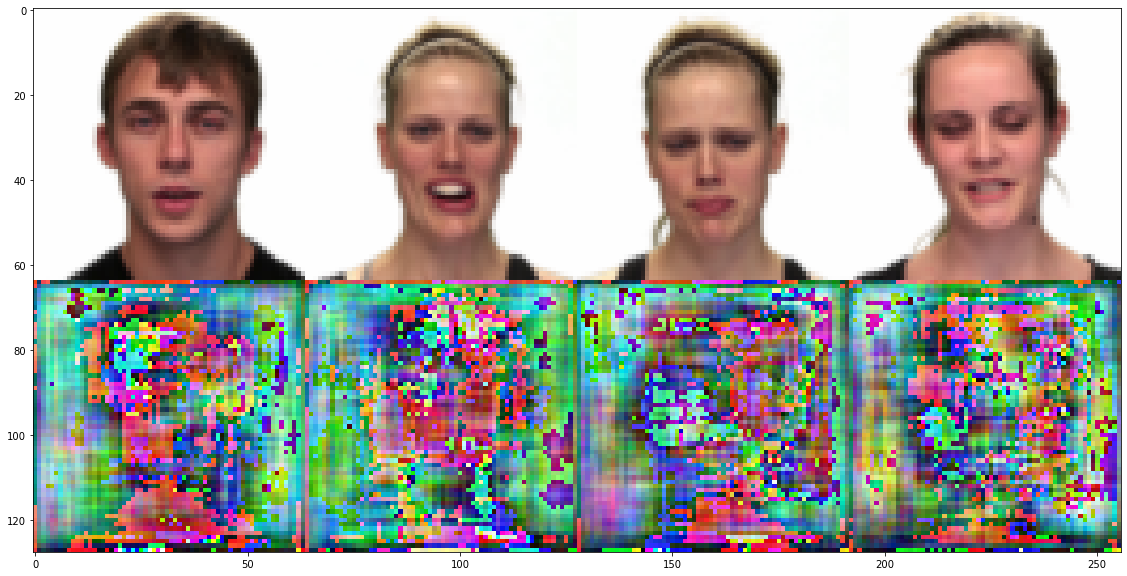

In [14]:
testBatch(model, testset_loader)

In [15]:
from tqdm import tqdm
def emotion_accuracy(model, dataset_loader):
    
    match = 0
    total = 0
    
    for sample in tqdm(iter(dataset_loader)):
        labels = sample['cat'].cuda()
                            
        _, reconstructed_emotions, _, _ = model(faces=None, emotions=labels)  
        emotion_cat = torch.argmax(reconstructed_emotions, 1)  
        
        for idx in range(len(labels)):
            total += 1
            if labels[idx] == emotion_cat[idx]:
                match += 1
    
    acc = match / total
    return acc

In [16]:
#print(emotion_accuracy(model, testset_loader))

In [18]:
save_model = True

if save_model:
    
    PATH = cfg_train.model_save_path
    torch.save({'model_params' : model.state_dict(),
                'model_args' : model_args}, PATH)

['surprised', 'sad', 'calm', 'fearful']
['fearful', 'sad', 'angry', 'surprised']


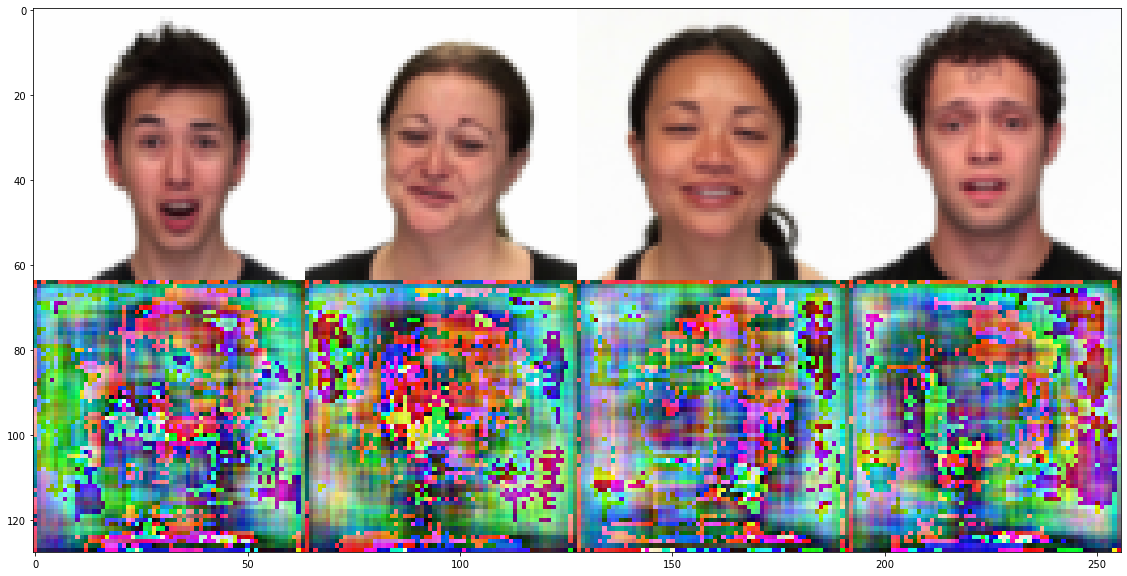

In [20]:
load_model = True

if load_model:    
    PATH = cfg_train.model_save_path
    loaded_data = torch.load(PATH)
    
    loaded_model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
    loaded_model.load_state_dict(loaded_data['model_params'])
    
    loaded_model.eval()
    
    testBatch(loaded_model, dataset_loader)